In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [15]:
sp_100 = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN',
    'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C',
    'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS',
    'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EMR', 'F', 'FDX', 'GD',
    'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC',
    'INTU', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA',
    'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT',
    'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM',
    'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS',
    'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT',
    'XOM', 'DOW', 'PYPL', 'KHC'
]
len(sp_100)

101

In [16]:
dataset = yf.download(sp_100, start="1990-01-01", interval='1mo')['Adj Close']
dataset = dataset.pct_change().fillna(0)

[*********************100%%**********************]  101 of 101 completed


In [17]:
train_df, test_df = train_test_split(dataset, test_size=0.2, shuffle=False, random_state=43)
len(train_df), len(test_df)

(332, 83)

In [18]:
W = 24
T = 4

In [19]:
X_train = []
for i in range(len(train_df.values)-T-W):
    Sigmas = []
    mu = []
    for j in range(T):
        cov_matrix_j = train_df.iloc[i+j:i+j+W-T].cov().values
        mu_j = train_df.iloc[i+j:i+j+W-T].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = train_df.iloc[i:i+W]
    pred = train_df.iloc[i+W:i+W+T]
    X_train.append([hist, np.stack(mu), np.stack(Sigmas), pred])

X_test = []
for i in range(len(test_df.values)-T-W):
    Sigmas = []
    mu = []
    for j in range(T):
        cov_matrix_j = test_df.iloc[i+j:i+j+W-T].cov().values
        mu_j = test_df.iloc[i+j:i+j+W-T].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = test_df.iloc[i:i+W]
    pred = test_df.iloc[i+W:i+W+T]
    X_test.append([hist, np.stack(mu), np.stack(Sigmas), pred])
                        

In [20]:
len(X_train), len(X_test)

(304, 55)

In [21]:
def mean_variance_multi_period_op(mu_returns, cov_matrices, trade_cost=0.0025, risk_tolerance_coefficient=0.25):
    T = mu_returns.shape[0]
    num_assets = mu_returns.shape[1]

    weights = cp.Variable((T, num_assets))

    constraints = []
    for i in range(T):
        constraints.append(weights[i,:] <= 0.1) # This Constaint specifices the maximum allocation allowed to a single stock. 10% of the portfolio.
        constraints.append(weights[i,:] >= 0.001) # This Constraint specifies the minimum allocation to each stock. 0.001 of the portfolio
        constraints.append(cp.sum(weights[i,:]) == 1)

    objective = 0
    for i in range(T):
        portfolio_return = (weights[i]@mu_returns[i]).sum()
        portfolio_risk = risk_tolerance_coefficient*cp.quad_form(weights[i], cov_matrices[i])
        portfolio_objective_i = portfolio_return - portfolio_risk
        objective += portfolio_objective_i
    
    portfolio_rebalancing_cost = trade_cost*cp.abs((weights[1:,:] - weights[:-1,:])).sum()
    objective -= portfolio_rebalancing_cost

    problem = cp.Problem(cp.Maximize(objective), constraints)
    problem.solve()

    optimal_weights = weights.value
    return optimal_weights


In [22]:
result_mv = []
for hist, mu, Sigma, pred in X_test:
   mv_opt_weights = mean_variance_multi_period_op(mu, Sigma)
   result_mv.append(pred.iloc[0]*mv_opt_weights[0])

In [23]:
result_mv = pd.concat(result_mv, axis=1).T.sum(1)
result_mv = np.cumsum(result_mv)

In [24]:
sp100_etf = yf.download("^OEX", start="1990-01-01", interval='1mo')['Adj Close']
sp100_etf = sp100_etf.pct_change().fillna(0)

[*********************100%%**********************]  1 of 1 completed


In [25]:
sp100_etf = sp100_etf[result_mv.index]
sp100_etf = np.cumsum(sp100_etf)

<Figure size 600x400 with 0 Axes>

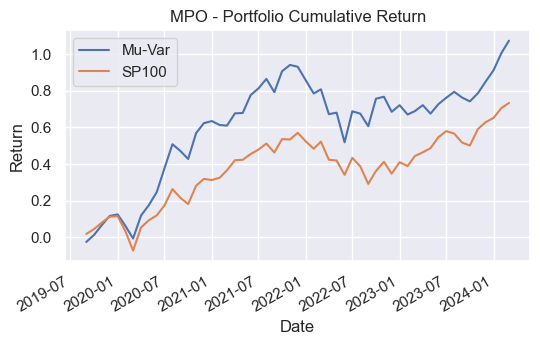

In [37]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(result_mv, label='Mu-Var')
ax.plot(sp100_etf, label='SP100')
ax.set_ylabel('Return')
ax.set_xlabel("Date")
ax.legend()
plt.title("MPO - Portfolio Cumulative Return")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()